# Кластеризация. Домашнее задание

### Данные

В предложенных файлах информация с публичных слушаний Москвы по правилам землепользования и застройки (ПЗЗ). В них комментарии жителей города были застенагрофированы, проклассифицированы (за/против) и нанесены на карту. Данные предоставлены в 2 вариантах, для задания можно использовать любой:
* geo_comment.xlsx
    * **comment** - комментарий одного или списка жителей к проект
    * **multiplier** - количество авторов комментария (может быть 1, может быть список)
    * **x, y** - координаты адреса, по которому был дан определённой комментарий
    * **comment_class** - за (1) / против (-1)
* geo.xlsx - те же данные, но без текстов комментариев и по 1 голосу на строку (ранее в 1 строке могло быть **multiplier** > 1 голоса)
    * **x, y** - координаты адреса, по которому был дан определённой комментарий
    * **comment_class** - за (1) / против (-1)
    
### Обязательное задание

* визуально разделить город на районы безотносительно голосов (провести кластеризацию и вывести картинку)
* аналогично исследовать скопления голосов за и против отдельно
* *подобрать оптимальное число кластеров при помощи кода из тетрадки в конце занятия (оптимально)*
* приложить ноутбук

### Дополнительные задания
* найти наиболее активные в голосовании районы *(подсказка: DBSCAN, не плотные районы обозначены одной меткой и закрашены одним цветом, cmap='gray')*
* для тех, кто уже попробовал работу с текстом: выделить основные тематики комментариев жителей, можно использовать всю имеющуюся дополнительную информацию

In [1]:
import pandas as pd
import numpy as np
df = pd.read_excel('geo_comment.xlsx')
df.head()

,Unnamed: 0,x,y,comment_class,multiplier,comment
0,0,37.612416,55.777454,-1,1,Во все разделы правил землепользования и застр...
1,1,37.612416,55.777454,-1,1,На основании вступившего в законную силу судеб...
2,2,37.603298,55.742108,-1,1,Внести в Проект правил землепользования и заст...
3,3,37.558526,55.728758,-1,1,Учитывая социальную значимость проекта строите...
4,4,37.566431,55.731794,-1,1,Учитывая социальную значимость проекта строите...


In [2]:
from matplotlib import pyplot as plt
plt.scatter(df.x, df.y, [0.2 for s in range(len(df))], df.comment_class, cmap='flag')
plt.show()

<Figure size 640x480 with 1 Axes>

подобрать оптимальное число кластеров при помощи кода из тетрадки в конце занятия (оптимально)

In [3]:
X = df[['x','y']]

In [4]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [5]:
from sklearn.cluster import KMeans

k_inertia = []
ks = range(1,10)

for k in ks:
    clf_kmeans = KMeans(n_clusters=k)
    clusters_kmeans = clf_kmeans.fit_predict(X_scaled, )
    k_inertia.append(clf_kmeans.inertia_)

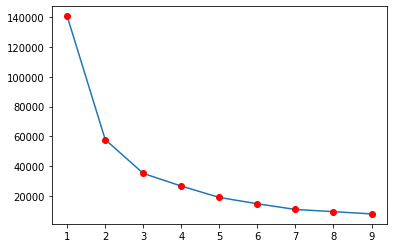

In [6]:
plt.plot(ks, k_inertia)
plt.plot(ks, k_inertia ,'ro')

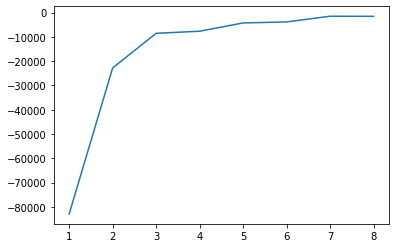

In [7]:
diff = np.diff(k_inertia)
plt.plot(ks[:-1], diff)

In [8]:
diff_r = diff[1:] / diff[:-1]
k_opt = ks[np.argmin(diff_r)+1]
k_opt

2

визуально разделить город на районы безотносительно голосов (провести кластеризацию и вывести картинку)

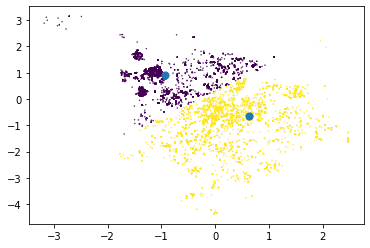

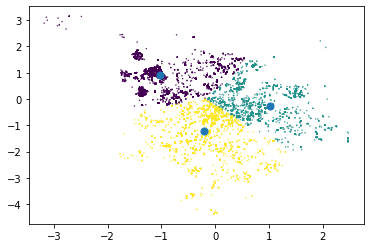

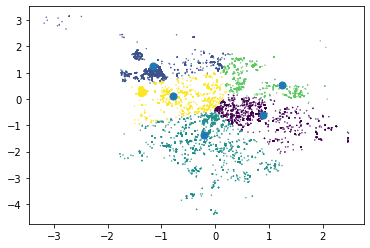

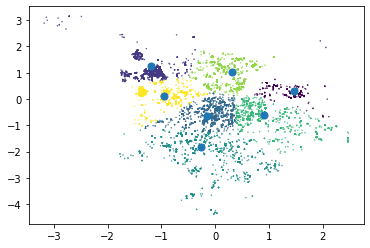

In [9]:
for k in (2,3,5,7):
    clf_kmeans = KMeans(n_clusters=k)
    clusters = clf_kmeans.fit_predict(X_scaled, )
    centers = clf_kmeans.cluster_centers_
    from matplotlib import pyplot as plt
    plt.scatter(X_scaled[:,0], X_scaled[:,1], [0.2 for s in range(len(df))], clusters)
    plt.scatter(centers[:, 0], centers[:, 1], s=50)
    plt.show()

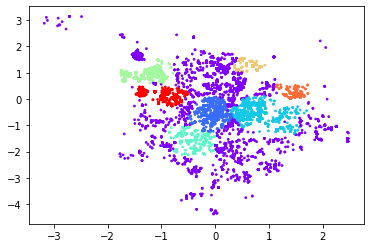

In [10]:
from sklearn.cluster import DBSCAN
clf_dbscan = DBSCAN(eps=0.22, min_samples=1000)
clusters = clf_dbscan.fit_predict(X_scaled, )
scatter = plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap='rainbow', s=3)

На самом деле, мне все равно не нравится полученный результат кластеризации. 
В городе явно есть большие районы с невысокой плотностью населения, 
в тоже время есть маленькие районы с высокой плотностью. Если я выбираю маленький эпсилон, 
то большие негустые районы не распознаются как кластеры, а если я выбриаю большой эпсилон, 
то друг с другом сливаются соседние маленькие густонаселенные районы. Поэтому я сделаю кластеризацию в 2 этапа. 
Сначала найду маленькие густонаселенные районы, а потом оставшиеся кластеризую с бОльшим эпсилоном. 

In [11]:
def get_cluster_name(row, cl_clm_nm, prefix):
    cluster = row[cl_clm_nm];
    if cluster == -1:
        return -1
    if np.isnan(cluster) :
        return row['cluster']
    return str(prefix) + "_" + str(int(cluster)) 

def find_clusters_for_not_yet_clustered(X_clustered, eps, min_samples):
    """
    Функция принимает на вход датафрейм с координатами и колонкой 'cluster'.
    Вычисляет кластера с применением eps для тех записей, у которых текущий кластер -1.
    Добавляет в имя кластера в качестве постфикса соответствующий eps
    """
    X_to_cluster = X_clustered[X_clustered['cluster'] == -1].copy()
    X_to_cluster_scaled = scaler.transform(X_to_cluster[['x','y']])
    clf_dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    clusters = clf_dbscan.fit_predict(X_to_cluster_scaled, )
    cl_clm_nm = 'cluster_' + str(eps)
    X_to_cluster[cl_clm_nm] = clusters
    X_clustered_copy = X_clustered.merge(X_to_cluster[['index', cl_clm_nm]], on='index', how='left')
    X_clustered_copy.loc[:,'cluster'] = X_clustered_copy.apply(get_cluster_name, args=(cl_clm_nm, eps), axis=1)
    return X_clustered_copy

In [12]:
def clusterize(X, dense_coef=1):
    """
    dense_coef нужен, поскольку параметры кластеризации настроены на полную выборку,
    а когда мы будем анализировать голоса "за" и "против", то они будут более разрежены
    """
    X_clustered = X.reset_index()
    X_clustered['cluster'] = -1

    X_clustered = find_clusters_for_not_yet_clustered(X_clustered, 0.1/dense_coef, 5000*dense_coef)
    X_clustered = find_clusters_for_not_yet_clustered(X_clustered, 0.2/dense_coef, 4000*dense_coef)
    X_clustered = find_clusters_for_not_yet_clustered(X_clustered, 0.4/dense_coef, 3000*dense_coef)
    X_clustered = find_clusters_for_not_yet_clustered(X_clustered, 0.8/dense_coef, 2000*dense_coef)
    X_clustered = find_clusters_for_not_yet_clustered(X_clustered, 1.6/dense_coef, 1000*dense_coef)
    return X_clustered

In [13]:
X_clustered = clusterize(X)
X_clustered.groupby('cluster').count()

,index,x,y,cluster_0.1,cluster_0.2,cluster_0.4,cluster_0.8,cluster_1.6
cluster,,,,,,,,
-1,71,71,71,71,71,71,71,71
0.1_0,7341,7341,7341,7341,0,0,0,0
0.1_1,7765,7765,7765,7765,0,0,0,0
0.2_0,4903,4903,4903,4903,4903,0,0,0
0.2_1,6698,6698,6698,6698,6698,0,0,0
0.2_2,5363,5363,5363,5363,5363,0,0,0
0.2_3,5952,5952,5952,5952,5952,0,0,0
0.4_0,12117,12117,12117,12117,12117,12117,0,0
0.4_1,5310,5310,5310,5310,5310,5310,0,0


In [14]:
import sklearn.preprocessing as preprocessing
from pylab import rcParams

def show_clusters(X_clustered, ax):
    le = preprocessing.LabelEncoder()
    labels = list(X_clustered['cluster'].unique())
    le.fit(labels)
    numbers = le.transform(labels)
    labels = le.inverse_transform(numbers)
    label_map = {l:n for l, n in zip(labels, numbers)}
    for label in sorted(label_map):
        print(f"{label} : {label_map.get(label)}")
    X_clustered['c_label'] = le.transform(list(X_clustered['cluster']))
    
    scatter = ax.scatter(X_clustered["x"], X_clustered["y"], [10 for s in range(len(X_clustered))], c=X_clustered['c_label'], cmap='rainbow')
    # produce a legend with the unique colors from the scatter
    legend1 = ax.legend(*scatter.legend_elements(),
                        loc="lower left", title="Classes")
    ax.add_artist(legend1)

-1 : 0
0.1_0 : 1
0.1_1 : 2
0.2_0 : 3
0.2_1 : 4
0.2_2 : 5
0.2_3 : 6
0.4_0 : 7
0.4_1 : 8
0.8_0 : 9
1.6_0 : 10


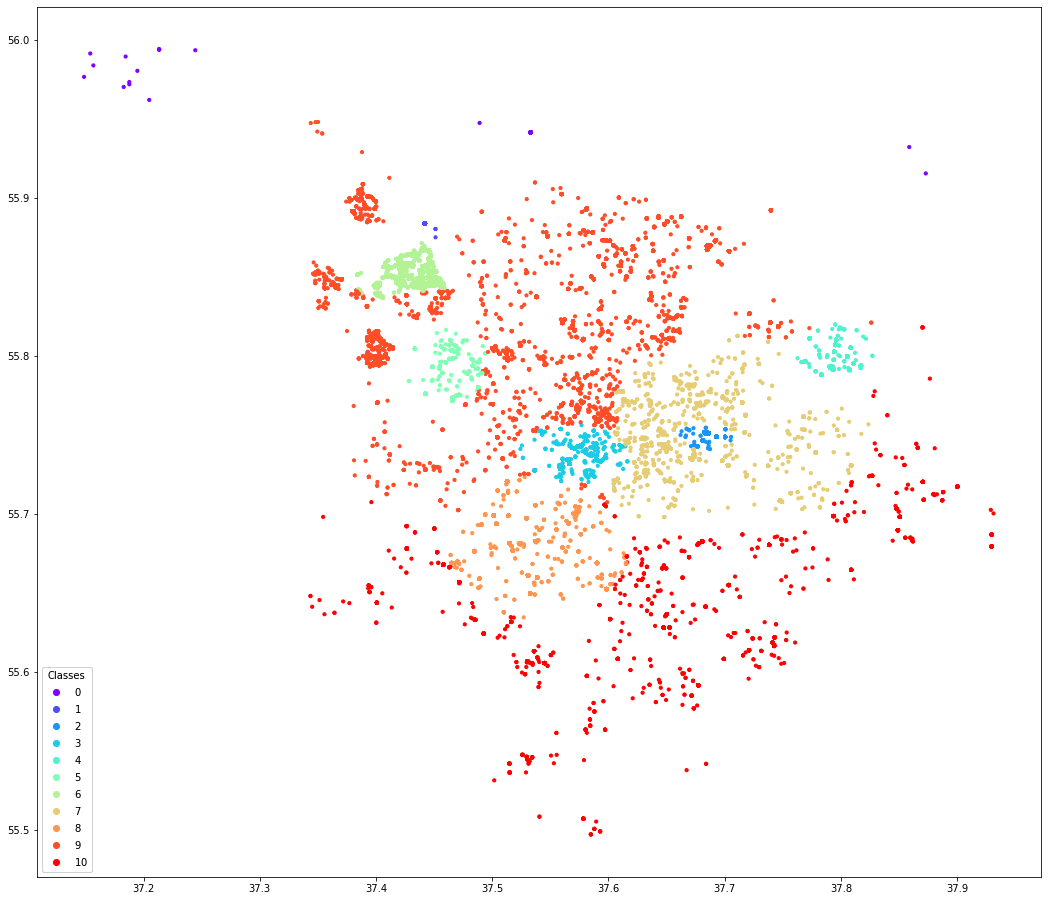

In [15]:
fig, ax = plt.subplots(figsize=(18, 16))
show_clusters(X_clustered, ax)

Ну вот, теперь норм. Видно районы с высотками, где много жителей, видно окраины разной плотности.
Теперь исследуем отдельно районы за и против

In [17]:
positive_X = df[df.comment_class == 1]
negative_X = df[df.comment_class == -1]
positive_X_clustered = clusterize(positive_X)
negative_X_clustered = clusterize(negative_X)

-1 : 0
0.4_0 : 1
0.8_0 : 2
0.8_1 : 3
-1 : 0
0.1_0 : 1
0.1_1 : 2
0.2_0 : 3
0.4_0 : 4
0.4_1 : 5
0.4_2 : 6
0.8_0 : 7
1.6_0 : 8


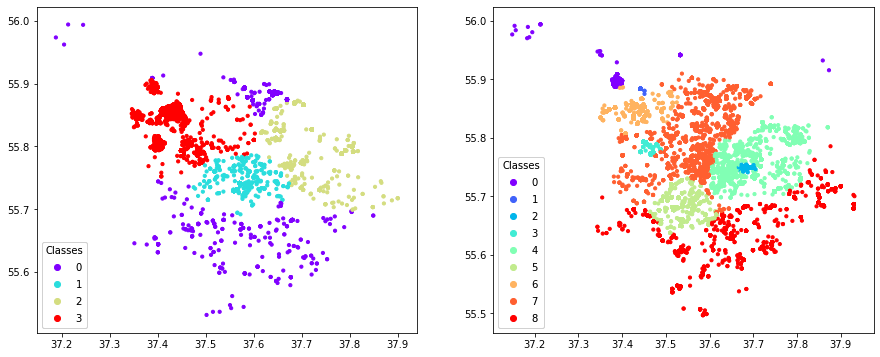

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
show_clusters(positive_X_clustered, axes[0])
show_clusters(negative_X_clustered, axes[1])

Сейчас мы можем увидеть, что голоса разделились немного не по тем же районам, которые мы определили, когда анализировали всю выборку, безотносительно от того, за что они голосовали.
А теперь посмотрим, не зря ли мы ввели dense_coef в функции clusterize. 

0.594945054945055_0 : 0
0.594945054945055_1 : 1
0.594945054945055_2 : 2
9.51912087912088_0 : 3
-1 : 0
0.12020426287744228_0 : 1
0.12020426287744228_1 : 2
0.24040852575488456_0 : 3
0.24040852575488456_1 : 4
0.24040852575488456_2 : 5
0.24040852575488456_3 : 6
0.24040852575488456_4 : 7
0.4808170515097691_0 : 8
0.9616341030195382_0 : 9


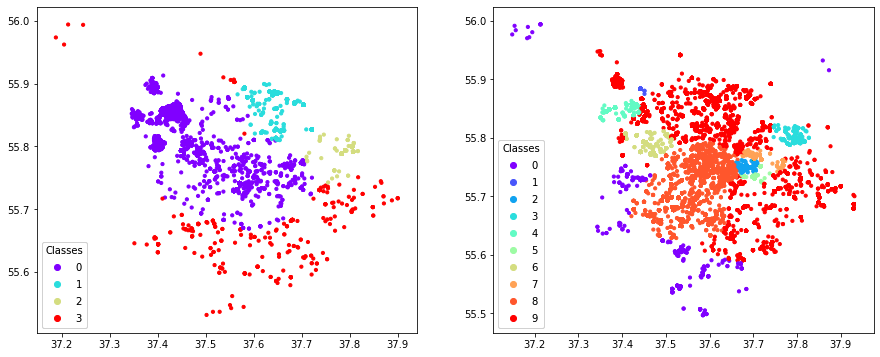

In [19]:
positive_dense_coef = len(positive_X)/len(df)
negative_dense_coef = len(negative_X)/len(df)
positive_X_clustered = clusterize(positive_X, positive_dense_coef)
negative_X_clustered = clusterize(negative_X, negative_dense_coef)
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
show_clusters(positive_X_clustered, axes[0])
show_clusters(negative_X_clustered, axes[1])

Красный кластер на первой картинке я не буду учитывать - его он был найден с eps=9.51912087912088_0, что слишком много. Остальные рассмотрю. Картина сложилась в целом похожая на ту, когда оценивали без dense_coef, хотя его добавление немного подчеркнуло общую тенденцию.
Сторонники (районы, где голосов "за" выше среднего), сконцетрировались в центре, северо-восткоке и северозападе. Что, на самом деле, довольно равномерно по городу, потому что в южной красной негустой зоне живут очень мало комментаторов вообще (всего 3% всех жителей).
Противники тоже есть везде, даже юго-восток заняли, где народу тоже негусто.

Интересно то, что не были обнаружены густозаселенные районы сторонников, что позволяет сделать вывод, что жители таких районов в основном голосуют против. Хотя такие районы все равно присоединяются к менее плотным кластерам сторонников, видимо чисто за счет большОго количества жителей. 

Из всего этого я бы с достаточной уверенностью мог бы сделать только один вывод - чем гуще район, тем меньше там сторонников данного законопроекта. И этот вывод удалось сделать только благодаря тому, что мы делали последовательную кластеризацию с разными eps.